In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

from tensorflow import keras
from tensorflow.keras import layers


%matplotlib inline

In [11]:
df = pd.read_csv('Data2.csv')
df2 = pd.read_csv('data_test.csv')
df.head(10)

,-0.251,-0.75,0.311,0.936,-0.681,0.686
0,-1.1300,-0.5540,0.8350,1.0500,0.4960,0.4050
1,-0.6810,-0.0947,0.7640,1.0200,0.4580,0.5030
2,-0.7740,0.2340,0.4320,0.9040,0.5920,0.7540
3,-0.7660,-0.1190,-0.0518,0.3720,0.5660,0.8520
4,-0.0641,-0.4940,0.2070,0.0263,0.4420,0.0676
5,0.1180,-0.9830,-0.3270,-1.1900,-0.0349,-0.3080
6,-1.4900,-1.1300,-0.2390,-1.6800,-1.7700,-0.1640
7,-1.3500,-0.9660,0.7230,-1.7100,1.2000,0.3480
8,-1.2100,-1.0100,0.8480,-1.3400,0.2420,-0.2340
9,-0.7070,-0.3030,1.3400,-0.7410,0.3820,-1.2900


In [16]:
y = np.array([0 for i in range(len(df))]) #정상데이터 - 0
x = df.to_numpy()
y2 = np.array([1 for i in range(len(df))])
x2 = df2.to_numpy()
print(x.shape)
print(x2.shape)

(202999, 6)
(150, 6)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, shuffle=False)
x_train = x_train[:int(x_train.shape[0]/20)*20,:]
y_train = y_train[:int(y_train.shape[0]/20)*20]
x_train = x_train.reshape(int(x_train.shape[0]/20), 20, x_train.shape[1])
x_test = np.concatenate([x_test, x2])
x_test = x_test[:int(x_test.shape[0]/20)*20,:]
x_test = x_test.reshape(int(x_test.shape[0]/20), 20, x_test.shape[1])

x_train_40 = []
x_test_40 = []
y_test_40 = []


#window size = 40
#window slide by 20
for i in range(len(x_train)-1):
    x_train_40.append(np.concatenate([x_train[i], x_train[i+1]], 0))
    
for i in range(len(x_test)-1):
    x_test_40.append(np.concatenate([x_test[i], x_test[i+1]], 0))
    if(len(x_test) - i - 1 <= 7):
        y_test_40.append(1)
    else:
        y_test_40.append(0)

x_train_40 = np.array(x_train_40)
x_test_40 = np.array(x_test_40)
y_test_40 = np.array(y_test_40)

print(x_train_40.shape)
print(x_test_40.shape)

(6799, 40, 6)
(3356, 40, 6)


In [6]:
from keras.layers import Activation, Dense, LSTM, TimeDistributed
def create_baseline():
    model = keras.Sequential(
    [
        #Encoder
        layers.LSTM(32, input_shape = (x_train_40.shape[1],x_train_40.shape[2]), 
                    activation="relu", return_sequences=True),
        layers.LSTM(64, activation="relu", return_sequences=True),
        #Decoder
        layers.LSTM(64, activation="relu", return_sequences=True),
        layers.LSTM(32, activation="relu", return_sequences=True),
        layers.TimeDistributed(Dense(x_train_40.shape[2]))
    ]
    )

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [7]:
model = create_baseline()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 32)            4992      
                                                                 
 lstm_1 (LSTM)               (None, 40, 64)            24832     
                                                                 
 lstm_2 (LSTM)               (None, 40, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 40, 32)            12416     
                                                                 
 time_distributed (TimeDistr  (None, 40, 6)            198       
 ibuted)                                                         
                                                                 
Total params: 75,462
Trainable params: 75,462
Non-trainable params: 0
____________________________________________________

In [8]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(x_train_40, x_train_40, batch_size=16, epochs=30, 
                    callbacks=callbacks, validation_data=(x_test_40, x_test_40))

val_loss = history.history['val_loss']
loss = history.history['loss']

Epoch 1/30
425/425 [==============================] - 18s 37ms/step - loss: 0.6808 - val_loss: 0.4987
Epoch 2/30
425/425 [==============================] - 19s 45ms/step - loss: 0.1908 - val_loss: 0.1131
Epoch 3/30
425/425 [==============================] - 21s 49ms/step - loss: 0.0403 - val_loss: 0.0297
Epoch 4/30
425/425 [==============================] - 21s 49ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 5/30
425/425 [==============================] - 19s 45ms/step - loss: 0.0085 - val_loss: 0.0094
Epoch 6/30
425/425 [==============================] - 18s 41ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 7/30
425/425 [==============================] - 18s 42ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 8/30
425/425 [==============================] - 18s 42ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 9/30
425/425 [==============================] - 18s 42ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 10/30
425/425 [==============================] - 18s 42ms/step - loss: 0.002

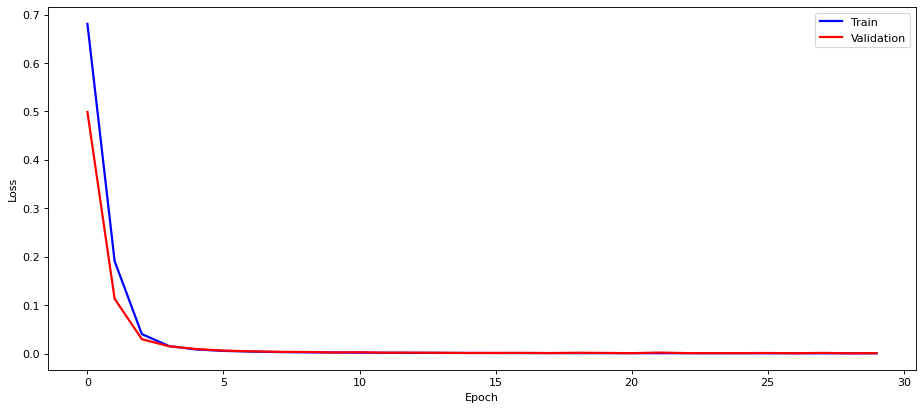

In [9]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(loss, 'b', label='Train', linewidth=2)
ax.plot(val_loss, 'r', label="Validation", linewidth=2)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [20]:
import pandas as pd
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

prediction = model.predict(x_test_40)

mse = np.mean(np.power(x_test_40 - prediction, 2), axis=1)
thresholds = []

for i in range(6):
    curr_mse = mse[0:, i:i+1]
    curr_mse = curr_mse.reshape(x_test_40.shape[0])

    error_df = pd.DataFrame({'Reconstruction_error':curr_mse,
                        'True_class':y_test_40})
    pre, rec, ths = metrics.precision_recall_curve(error_df['True_class'], 
                                                   error_df['Reconstruction_error'])
    best_cnt = abs(pre-rec)

    ths_fixed = ths[np.argmin(best_cnt)]
    thresholds.append(ths_fixed)
    
    print("Threshold",i+1,": ", ths_fixed)


Threshold 1 :  8.881105017598676
Threshold 2 :  4.359409934044948
Threshold 3 :  1.816310349586054
Threshold 4 :  2.990228150160638
Threshold 5 :  2.420736065096308
Threshold 6 :  4.574086348390363


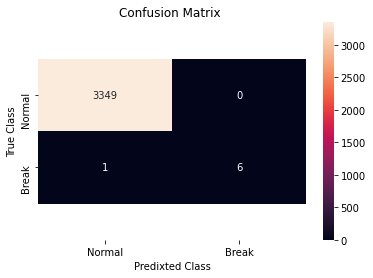

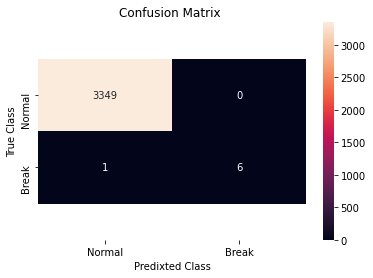

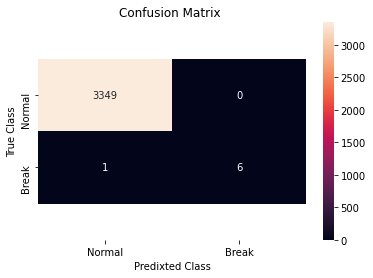

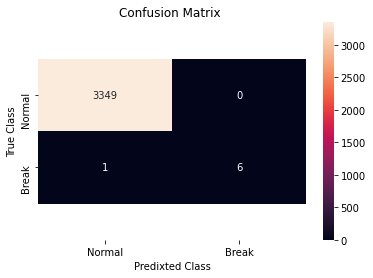

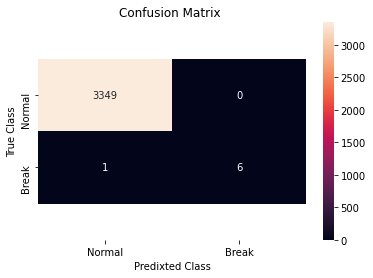

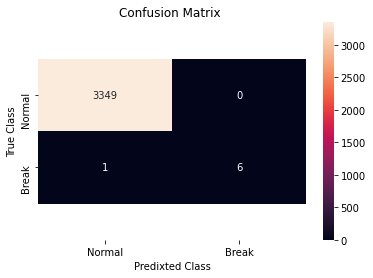

Accuarcy:  0.9997020262216925
Detection Accuracy:  0.8571428571428571


In [29]:
#accuracy

import pandas as pd
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

prediction = model.predict(x_test_40)

mse = np.mean(np.power(x_test_40 - prediction, 2), axis=1)

a = []
da = []

for i in range(6):
    curr_mse = mse[0:, i:i+1]
    curr_mse = curr_mse.reshape(x_test_40.shape[0])

    error_df = pd.DataFrame({'Reconstruction_error':curr_mse,
                        'True_class':y_test_40})
    pred_y = [1 if e > thresholds[i] else 0 for e in error_df['Reconstruction_error'].values]
    conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
    
    accuracy = (conf_matrix[0][0]+conf_matrix[1][1])/conf_matrix.sum()
    daccuracy = (conf_matrix[1][1])/7
    a.append(accuracy)
    ad.append(daccuracy)
    
    sns.heatmap(conf_matrix, xticklabels=['Normal', 'Break'], 
                yticklabels=['Normal', 'Break'], annot=True, fmt='d')
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.title('Confusion Matrix ')
    plt.xlabel('Predixted Class')
    plt.ylabel('True Class')
    plt.show()
print('Accuarcy: ', sum(a)/6)
print('Detection Accuracy: ', sum(da)/6)


In [37]:
model.save("tensorModel_220611.h5")